In [1]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import time

import cudf
import cuml
import os
import gc
import joblib

import mlflow

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE

# import optuna
# from optuna.storages import JournalStorage, JournalFileStorage, RDBStorage


import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
from src.modeling.p7_util import format_time, save_pkl, read_pkl
from src.modeling.p7_constantes import (
    DATA_CLEAN_DIR,
    DATA_INTERIM,
    MODEL_DIR,
    VAL_SEED,
)

from src.modeling.p7_util import reduce_memory_cudf, read_train, read_pkl
from src.modeling.p7_evaluate import EvaluatorCV, Evaluator
from src.modeling.p7_importance import (
    importance_from_model,
    plot_line_importance,
    plot_bar_importances,
)
from src.modeling.p7_tracking import log_features, log_scoring_params, log_image
from src.modeling.p7_comparative_table import ComparativeTable
from src.modeling.p7_rfecv import RfecvSelector
from src.modeling.p7_tracking import start_mlflow_ui, create_or_load_experiment

from src.modeling.p7_optimize import OptimLogReg, OptimLgbm, OptimThreshold


%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

In [8]:
# On ignore les warnings car les solvers ne vont pas toujours converger
warnings.filterwarnings("ignore")

In [4]:
pd.set_option("display.max_colwidth", 400)

In [5]:
print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)
print("mlflow version:", mlflow.__version__)

cuDF version: 24.04.01
cuML version: 24.04.00
mlflow version: 2.13.0


In [62]:
features = read_pkl("features_rfecv_lightgbm")
X, y = read_train()

Objet list lu dans models/features_rfecv_lightgbm.pkl
Memory usage of dataframe is 532.18 MB
Memory usage after optimization is: 303.43 MB
Decreased by 43.0%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Empty DataFrame


# Rappel : pararamètres de la métrique

In [6]:
PARAM_BG = {
    "loss_fn": -10,
    "loss_fp": -1,
    "gain_tn": 1,
    "gain_tp": 1,
}

In [7]:
print("Paramètres de la métrique")
print(PARAM_BG)

Paramètres de la métrique
{'loss_fn': -10, 'loss_fp': -1, 'gain_tn': 1, 'gain_tp': 1}


# Optimisation Régression Logistique

## Principaux paramètres à optimiser

In [ ]:
"""
C : plus C est petit, plus la régulation est forte
trial.suggest_loguniform("C", 1e-5, 1e2)

Penalty : Type de régularisation
trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])

solver :
En sklearn : "liblinear", "saga", "lbfgs", "newton-cg", "sag"
"liblinear" : supporte l1 et l2
"saga" : supporte l1, l2, elasticnet, none
"lbfgs", "newton-cg", "sag" : seulement l2 ou none
trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"])

L1_ratio
Uniquement si penalty=="elasticnet"
(requis seulement si penalty="elasticnet" et solver="saga")
trial.suggest_float("l1_ratio", 0.0, 1.0)

max_iter
Peut être augmenté pour assurer la convergence (surtout si saga ou elasticnet)
trial.suggest_int("max_iter", 100, 1000)
"""

'\nC : plus C est petit, plus la régulation est forte\ntrial.suggest_loguniform("C", 1e-5, 1e2)\n\nPenalty : Type de régularisation\ntrial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])\n\nsolver :\nEn sklearn : "liblinear", "saga", "lbfgs", "newton-cg", "sag"\n"liblinear" : supporte l1 et l2\n"saga" : supporte l1, l2, elasticnet, none\n"lbfgs", "newton-cg", "sag" : seulement l2 ou none\ntrial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"])\n\nL1_ratio\nUniquement si penalty=="elasticnet"ArithmeticError\n(requis seulement si penalty="elasticnet" et solver="saga")\ntrial.suggest_float("l1_ratio", 0.0, 1.0)\n\nmax_iter\nPeut être augmenté pour assurer la convergence (surtout si saga ou elasticnet)\ntrial.suggest_int("max_iter", 100, 1000)\n'

## Optimisation des hyperparamètres et du seuil de probabilité en même temps

In [38]:
_ = start_mlflow_ui()

L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000


In [ ]:
# On fait un essai sur un échantillon
logreg_features = read_pkl("features_rfecv_logreg")
X, y = read_train(train_name="01_v2_vif_sampled_train.csv", features=logreg_features)

Objet list lu dans models/features_rfecv_logreg.pkl
Memory usage of dataframe is 41.19 MB
Memory usage after optimization is: 23.24 MB
Decreased by 43.6%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 69190 entries, 365328 to 279329
Columns: 103 entries, CODE_GENDER to CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
dtypes: bool(32), float32(64), float64(2), int32(3), int64(2)
memory usage: 22.4 MB


In [17]:
t0 = time.time()
study_logreg = OptimLogReg(
    X,
    y,
    fixed_params={
        "max_iter": 200,
        "n_jobs": 14,
        "random_state": VAL_SEED,
    },
    to_suggest=["solver", "C", "penalty", "l1_ratio", "threshold_prob"],
    mlflow_experiment_name="optim_0_logreg",
)
study_logreg.optimize(n_trials=50)
duration = time.time() - t0
print("Durée de l'optimisation (hh:mm:ss) :", format_time(duration))

[I 2025-05-29 05:45:55,032] A new study created in memory with name: no-name-f6918044-6616-4e61-b29e-fb30f958c0eb


L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000
Création de l'expérience MLFlow 'optim_0_logreg', ID = 566155037151596890


[I 2025-05-29 05:46:01,191] Trial 0 finished with value: 0.30569764223100837 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.769930294063335e-05, 'threshold_prob': 0.14646688973455957}. Best is trial 0 with value: 0.30569764223100837.
[I 2025-05-29 05:47:45,604] Trial 1 finished with value: 0.5646880619340813 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 4.566054873446129, 'threshold_prob': 0.26987128854262094}. Best is trial 1 with value: 0.5646880619340813.
[I 2025-05-29 05:47:45,637] Trial 2 pruned. 
[I 2025-05-29 05:48:37,804] Trial 3 finished with value: 0.7396627660876991 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.0044520483657488515, 'threshold_prob': 0.728140769114411}. Best is trial 3 with value: 0.7396627660876991.
[I 2025-05-29 05:48:48,845] Trial 4 finished with value: 0.6945316231777717 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 2.3130924416844105e-05, 'l1_ratio': 0.06505159298527952, 'threshold_prob': 0.8591

Meilleur Business Gain : 0.7397
Meilleurs hyperparamètres :
  penalty: l2
  solver: saga
  C: 0.0011632876557111334
  threshold_prob: 0.7219760208878505


Durée de l'optimisation (hh:mm:ss) : 0:29:20


## Conclusion de l'essai (hyperparams et threshold)

In [ ]:
"""
Nous n'aurions pas dû optimiser les hyperparamètres du modèle et en même temps le paramètre stratégique qui
est le seuil de décision (ou seuil de probabilité).
En effet, on voit dans le graphique des "Importance des paramètres" que le seuil est tellement sensible qu'il "écrase" tous les autres.
Autrement dit, son optimisation peut interférer avec l'optimisation des praramètres du modèle proprement dit et nuire à l'optimisation.
Nous allons donc optimiser d'abord les paramètres du modèle, puis avec ces paramètres optimiser le seuil de décision.
"""

## D'abord l'optimisation des hyperparamètres du modèle uniquement

In [11]:
logreg_features = read_pkl("features_rfecv_logreg")
X, y = read_train(train_name="01_v2_vif_train.csv", features=logreg_features)

Objet list lu dans models/features_rfecv_logreg.pkl
Memory usage of dataframe is 137.31 MB
Memory usage after optimization is: 81.00 MB
Decreased by 41.0%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Columns: 103 entries, CODE_GENDER to CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
dtypes: bool(32), float32(58), float64(8), int32(3), int64(2)
memory usage: 80.1 MB


In [12]:
t0 = time.time()
study_logreg = OptimLogReg(
    X,
    y,
    # Pour des raisons de temps de calcul, on fixe le maximum d'itérations à 200,
    # même si saga peut avoir besoin de plus pour converger.
    fixed_params={
        "max_iter": 200,
        "n_jobs": 14,
        "random_state": VAL_SEED,
    },
    to_suggest=["solver", "C", "penalty", "l1_ratio"],
    mlflow_experiment_name="optim_1_logreg_params",
)
study_logreg.optimize(n_trials=50)
duration = time.time() - t0
print("Durée de l'optimisation (hh:mm:ss) :", format_time(duration))

[I 2025-06-06 18:52:09,193] A new study created in memory with name: no-name-3814b5e2-6810-4da9-8cee-cff8d0fcc753


L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000
Chargement de l'expérience MLFlow 'optim_1_logreg_params', ID = 569007272505237624


[I 2025-06-06 18:52:31,818] Trial 0 finished with value: 0.6711647786679715 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.769930294063335e-05}. Best is trial 0 with value: 0.6711647786679715.
[I 2025-06-06 18:53:06,323] Trial 1 finished with value: 0.698864274589494 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 57.44851636320433}. Best is trial 1 with value: 0.698864274589494.
[I 2025-06-06 18:55:48,587] Trial 2 finished with value: 0.6989564893496008 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.01577798188336503}. Best is trial 2 with value: 0.6989564893496008.
[I 2025-06-06 18:57:37,521] Trial 3 finished with value: 0.6986957014524202 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.0008528933855762819, 'l1_ratio': 0.45606998421703593}. Best is trial 2 with value: 0.6989564893496008.
[I 2025-06-06 18:58:13,892] Trial 4 finished with value: 0.6989835236827908 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C':

Meilleur Business Gain : 0.6990
Meilleurs hyperparamètres :
  penalty: l1
  solver: saga
  C: 0.030918440514506536


Durée de l'optimisation (hh:mm:ss) : 1:42:26


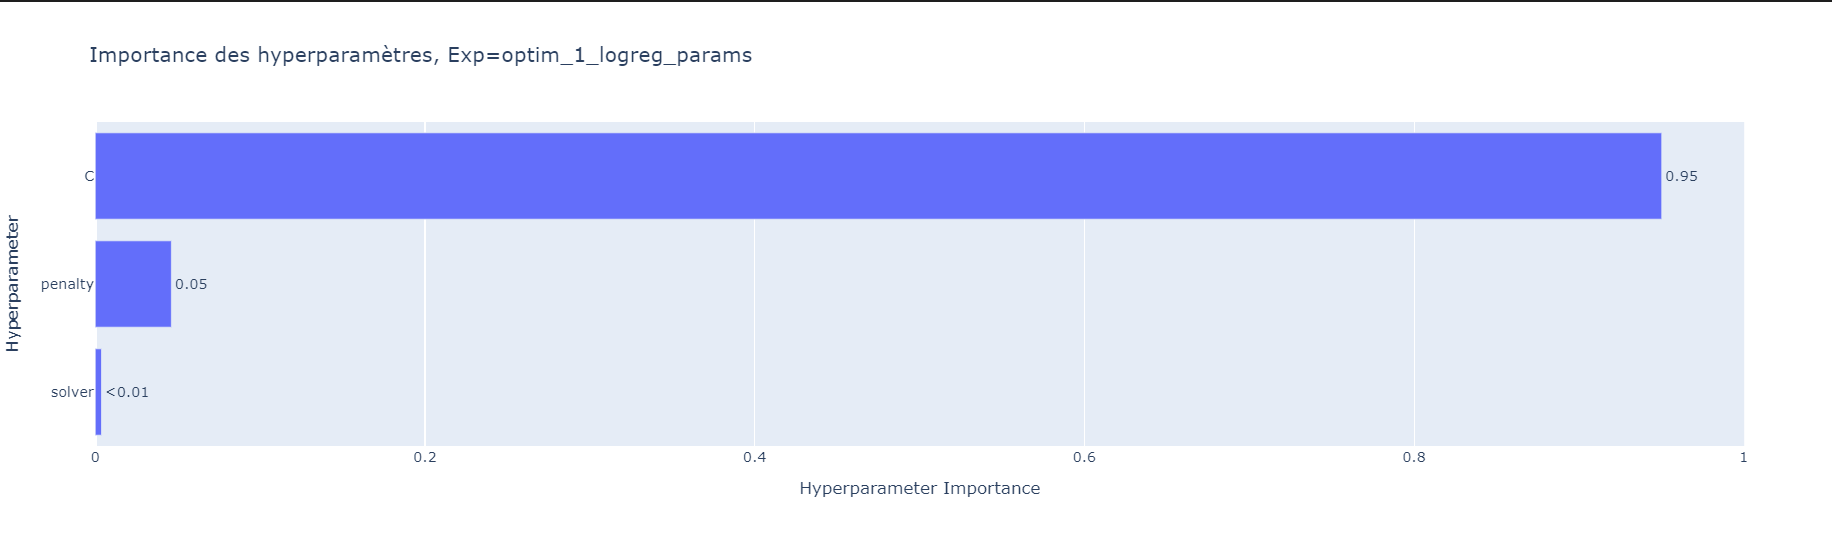
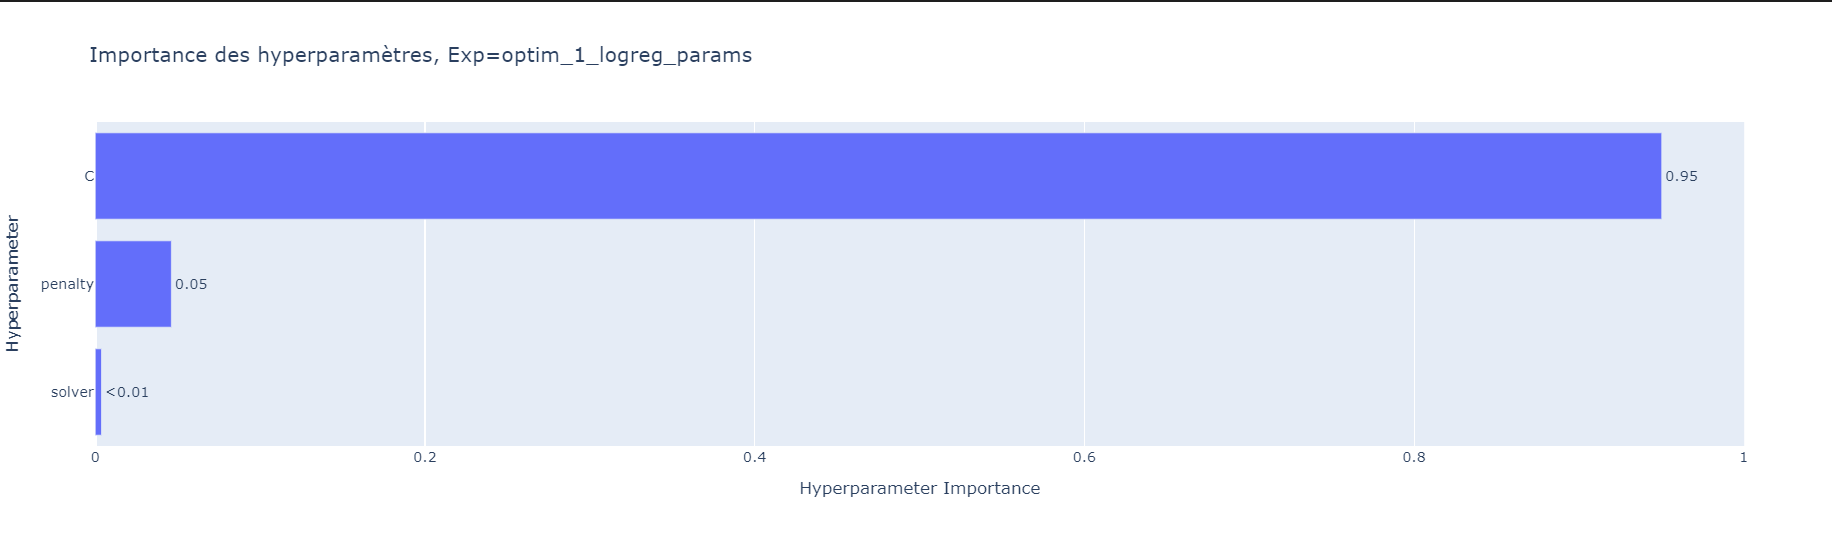

In [13]:
best_model_logreg = study_logreg.get_best_model()
best_model_logreg

LogisticRegression(C=0.030918440514506536, max_iter=200, n_jobs=14,
                   penalty='l1', random_state=42, solver='saga')

In [14]:
study_logreg.best_trial

{'model_params': {'C': 0.030918440514506536,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 200,
  'multi_class': 'deprecated',
  'n_jobs': 14,
  'penalty': 'l1',
  'random_state': 42,
  'solver': 'saga',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False},
 'bg_params': {'loss_fn': -10, 'loss_fp': -1, 'gain_tn': 1, 'gain_tp': 1},
 'threshold_prob': 0.5,
 'val_scores': {'auc': 0.7566480201027952,
  'accuracy': 0.7104113099118454,
  'recall': 0.6677758396466693,
  'f1_score': 0.2714236457544691,
  'business_gain': 0.6990455284667965,
  'fit_time': 35.21504545211792,
  'tn': 30281.0,
  'tp': 2488.0,
  'fn': 1237.8,
  'fp': 12120.0},
 'trial_number': 15}

In [15]:
save_pkl(best_model_logreg, "best_model_logreg")
save_pkl(study_logreg.best_trial, "best_trial_logreg")

Objet LogisticRegression engistré(e) dans models/best_model_logreg.pkl
Objet dict (len = 5) engistré(e) dans models/best_trial_logreg.pkl


In [16]:
best_param_logreg = study_logreg.best_trial["model_params"]
best_param_logreg

{'C': 0.030918440514506536,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'deprecated',
 'n_jobs': 14,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Ensuite Optimisation du Seuil de probabilité après optimisation des hyperparamètre du modèle

L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000
Chargement de l'expérience MLFlow 'optim_2_logreg_threshold', ID = 250688265890647638
Optimisation du seuil de probabilité
	param Business Gain : loss_fn=-10, loss_fp=-1, gain_tn=1, gain_tp=1
	Nombre de folds : 5
	Nombre de seuils à chaque fold : 9

Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Meilleur seuil de probabilité :0.7000
Meilleur Business Gain : 0.7312


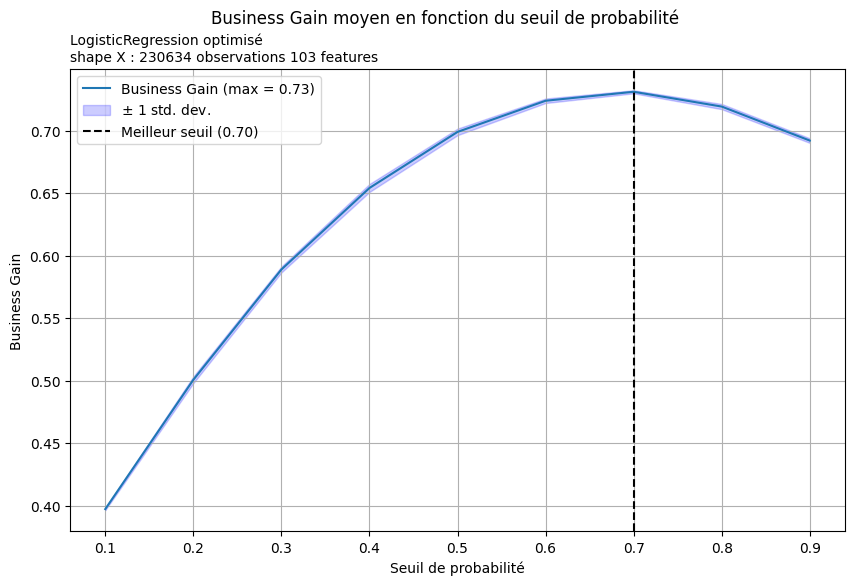

In [17]:
param_bg = {
    "loss_fn": -10,
    "loss_fp": -1,
    "gain_tn": 1,
    "gain_tp": 1,
}
model = best_model_logreg
# Pour des raisons de temps de calcul, on calule le business_gain à 9 seuils de probabilité seulement
# 0.1, 0.2 etc.
optim_logreg_threshold = OptimThreshold(
    model=model,
    n_thresholds=9,
    start=0.1,
    stop=0.9,
    mlflow_experiment_name="optim_2_logreg_threshold",
)

optim_logreg_threshold.optimize(X=X, y=y, param_bg=param_bg)

In [18]:
best_logreg_results = optim_logreg_threshold.best_results
best_logreg_results

{'model_params': {'C': 0.030918440514506536,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 200,
  'multi_class': 'deprecated',
  'n_jobs': 14,
  'penalty': 'l1',
  'random_state': 42,
  'solver': 'saga',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False},
 'bg_params': {'loss_fn': -10, 'loss_fp': -1, 'gain_tn': 1, 'gain_tp': 1},
 'threshold_prob': 0.7000000000000001,
 'business_gain': 0.7311652026828499}

In [19]:
# On arrondit le seuil à 2 chiffres après la virgule
best_threshold_logreg = round(best_logreg_results["threshold_prob"], 2)
best_threshold_logreg

0.7

## Evaluation en validation croisée avec traçage mlflow

In [20]:
exp_evaluation_id = create_or_load_experiment(
    name="eval_models",
    description="Evaluation des modèles en validation croisée sur le nombre optimal de features",
)

Chargement de l'expérience MLFlow 'eval_models', ID = 215726472202759917


In [21]:
# Pour enregistrer les modèles avec signature, on cast proprement les données
features = read_pkl("features_rfecv_logreg")
print()
X, y = read_train(features=features, clean_dtype=True)

Objet list lu dans models/features_rfecv_logreg.pkl

Memory usage of dataframe is 137.31 MB
Memory usage after optimization is: 81.00 MB
Decreased by 41.0%
Cast des features

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Columns: 103 entries, CODE_GENDER to CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
dtypes: float32(58), float64(13), int64(32)
memory usage: 132.0 MB


In [22]:
pipe = ImblearnPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=5, n_jobs=14, random_state=VAL_SEED)),
        (
            "clf",
            best_model_logreg,
        ),
    ]
)

evaluator = EvaluatorCV(
    pipe=pipe,
    device="cpu",
    cv=5,
    threshold_prob=best_threshold_logreg,
    random_state=VAL_SEED,
)
run_name = "logreg_smote_optimized"
run_tags = {"balancing": evaluator.balance_str, "optim": "Oui"}
run_description = "LogReg SMOTE features RFECV Hyperparamètres et seuil optimisés"
with mlflow.start_run(
    experiment_id=exp_evaluation_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator.evaluate(X, y)
    _ = evaluator.get_business_gain()

Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:02:56
Business gain Train : 0.7318,	Business gain Validation : 0.7312


In [23]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator.get_mean_val_scores(prefix="val_")
    train_scores = evaluator.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = evaluator.get_model_params()
    mlflow.log_params(params)

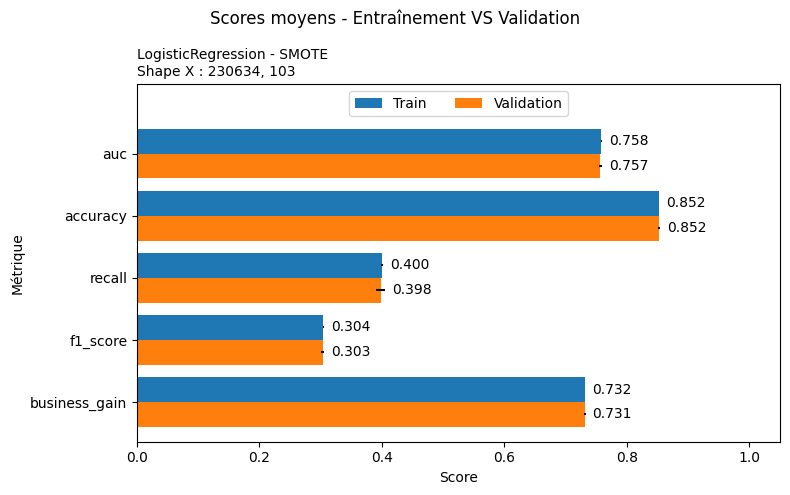

In [24]:
fig = evaluator.plot_evaluation_scores()

In [25]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_evaluation_scores")

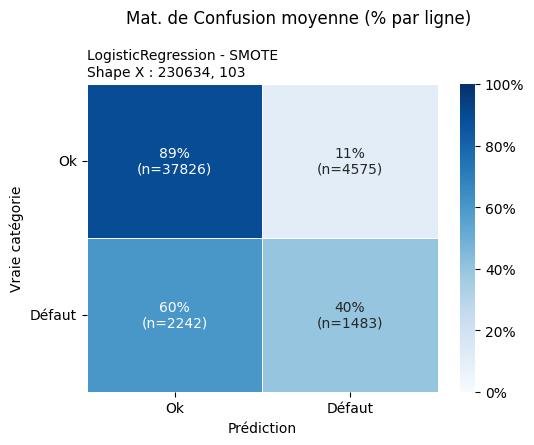

In [26]:
fig = evaluator.plot_conf_mat()
fig

In [27]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_confusion_matrix")

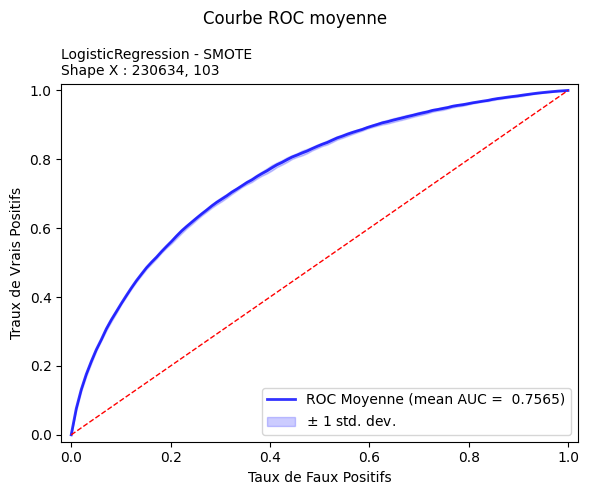

In [28]:
fig = evaluator.plot_roc_curve()

In [29]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_roc_curve")

In [30]:
with mlflow.start_run(run_id=run_id):
    log_features(X)

In [31]:
with mlflow.start_run(run_id=run_id):
    bg_params = evaluator.get_bg_params()
    threshold_prob = evaluator.threshold_prob
    log_scoring_params(bg_params, threshold_prob)

In [32]:
pipe.fit(X, y)

with mlflow.start_run(run_id=run_id):
    # On logue le modèle (il aparaîtra dans la colonne modèle de l'interface web mlflow)
    mlflow.sklearn.log_model(pipe, artifact_path="model")

    # On enregistre le modèle dans le Model Registry
    # En créant une nouvelle version
    model_uri = f"runs:/{run.info.run_id}/model"
    registered_model = mlflow.register_model(model_uri, name="LogReg")
    print(
        f"Modèle enregistré avec le nom : {registered_model.name}, et la version : {registered_model.version}"
    )

Registered model 'LogReg' already exists. Creating a new version of this model...
2025/06/06 21:17:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogReg, version 3


Modèle enregistré avec le nom : LogReg, et la version : 3


Created version '3' of model 'LogReg'.


## Enregistrement dans le tableau comparatif

In [33]:
# On reprend le tableau comparatif que nous avions débuté avant l'optimisation
dic_table = read_pkl(filename="cmp_eval_cv")
cmp_eval = ComparativeTable()
cmp_eval.table = dic_table
cmp_eval.set_column_format(
    dic_format={"threshold": "{:.2f}", "fit_time": "{:.1f}", "fn": "{:.1f}"}
)
cmp_eval.set_column_order(
    [
        "model_name",
        "balancing",
        "threshold",
        "business_gain",
        "auc",
        "recall",
        "f1_score",
        "fit_time",
        "fn",
        "n_feat.",
        "description",
    ]
)

cmp_eval.display()

Objet list lu dans models/cmp_eval_cv.pkl
Comparatif Modèles


model_name              balancing threshold business_gain     auc  \
0  LogisticRegression                  SMOTE      0.50        0.6990  0.7565   
1      LGBMClassifier  class_weight=balanced      0.50        0.7191  0.7801   

   recall f1_score fit_time      fn  n_feat.         description  
0  0.6677   0.2714      2.4  1238.2      103  Avant optimisation  
1  0.6839   0.2918      1.2  1177.8       87  Avant optimisation

In [34]:
# On ajoute le meilleur modèle de régression logistique optimisé au tableau comparatif
cmp_eval.add(evaluator=evaluator, tags={"description": "Optimisé"})
cmp_eval.display()

Comparatif Modèles


model_name              balancing threshold business_gain     auc  \
0  LogisticRegression                  SMOTE      0.50        0.6990  0.7565   
1      LGBMClassifier  class_weight=balanced      0.50        0.7191  0.7801   
2  LogisticRegression                  SMOTE      0.70        0.7312  0.7566   

   recall f1_score fit_time      fn  n_feat.         description  
0  0.6677   0.2714      2.4  1238.2      103  Avant optimisation  
1  0.6839   0.2918      1.2  1177.8       87  Avant optimisation  
2  0.3981   0.3032     33.9  2242.4      103            Optimisé

## Test du modèle sur le jeu de test

In [35]:
from src.modeling.p7_evaluate import Evaluator

In [36]:
# On ne trace pas dans mlflow car ce sont bien les résultats de validation croisés qui font foi
# En effet, les résultats sur le jeu de test dépendent de la graine de hasard que nous avons utilisés pour créer le jeu de test.
features = read_pkl("features_rfecv_logreg")
print()
X_train, y_train = read_train(features=features)
X_test, y_test = read_train(
    directory=DATA_INTERIM, train_name="01_v0_built_test.csv", features=features
)
print()

pipe = ImblearnPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=5, n_jobs=14, random_state=VAL_SEED)),
        (
            "clf",
            best_model_logreg,
        ),
    ]
)
testor = Evaluator(
    pipe=pipe,
    threshold_prob=best_threshold_logreg,
    random_state=VAL_SEED,
)


testor.evaluate(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)
_ = testor.get_business_gain()
val_scores = testor.get_test_scores(prefix="val_")
train_scores = testor.get_train_scores(prefix="train_")
scores = {**train_scores, **val_scores}

Objet list lu dans models/features_rfecv_logreg.pkl

Memory usage of dataframe is 137.31 MB
Memory usage after optimization is: 81.00 MB
Decreased by 41.0%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Columns: 103 entries, CODE_GENDER to CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
dtypes: bool(32), float32(58), float64(8), int32(3), int64(2)
memory usage: 80.1 MB
Memory usage of dataframe is 45.76 MB
Memory usage after optimization is: 26.11 MB
Decreased by 42.9%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 76877 entries, 209003 to 429566
Columns: 103 entries, CODE_GENDER to CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
dtypes: bool(32), float32(63), float64(3), int32(3), int64(2)
memory usage: 25.2 MB

Durée de l'évaluation : 0:00:42
Business gain Train : 0.7317,	Business gain Test : 0.7243


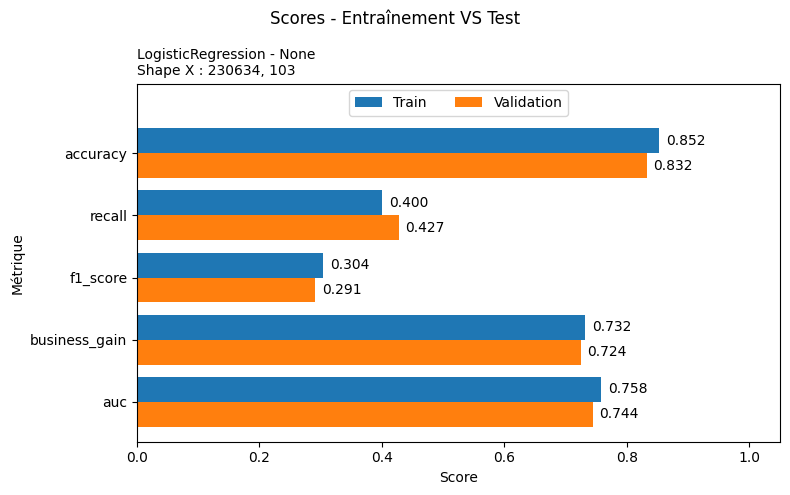

In [37]:
_ = testor.plot_evaluation_scores()

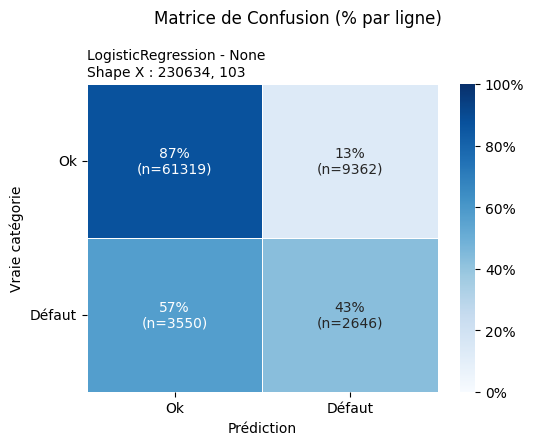

In [38]:
testor.plot_conf_mat()

# Optimisation LightGBM 87 features

## Paramètres à optimiser

In [ ]:
"""
"learning_rate",

"n_estimators",

"num_leaves" : Nombre maximal de feuilles (plus grand = plus complexe)

"min_child_samples" : Nombre minimum d'observations dans une feuille

"subsample" : Ratio de lignes échantillonées (bagging)

"colsample_bytree" : Ratio de colonnes échantillonées à chaque arbre

"reg_alpha" : Régularisation L1

"max_depth",

"min_split_gain" : Gain minimal pour faire un split

"""

## Optimisation des hyperparamètres

In [41]:
features_lgbm = read_pkl("features_rfecv_lightgbm")
X, y = read_train(features=features_lgbm)

Objet list lu dans models/features_rfecv_lightgbm.pkl
Memory usage of dataframe is 155.67 MB
Memory usage after optimization is: 92.33 MB
Decreased by 40.7%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Data columns (total 87 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   CODE_GENDER                            230634 non-null  int32  
 1   AMT_ANNUITY                            230626 non-null  float32
 2   REGION_POPULATION_RELATIVE             230634 non-null  float32
 3   DAYS_BIRTH                             230634 non-null  int64  
 4   DAYS_EMPLOYED                          189075 non-null  float32
 5   DAYS_REGISTRATION                      230634 non-null  float32
 6   DAYS_ID_PUBLISH                        230634 non-null  int64  
 7   OWN_CAR_AGE                            78227 non-null   float32
 8   REGION_RATING_CLIENT_W_

In [42]:
t0 = time.time()
optim_lgbm = OptimLgbm(
    X,
    y,
    fixed_params={
        "class_weight": "balanced",
        "objective": "binary",
        "n_jobs": 14,
        "random_state": VAL_SEED,
        "force_col_wise": True,
        "verbosity": -1,
    },
    to_suggest=[
        "learning_rate",
        "n_estimators",
        "num_leaves",
        "min_child_samples",
        "subsample",
        "colsample_bytree",
        "max_depth",
        "min_split_gain",
    ],
    mlflow_experiment_name="optim_3_lightGBM_params",
)

optim_lgbm.optimize(100)
duration = time.time() - t0
print("Durée de l'optimisation (hh:mm:ss) :", format_time(duration))

[I 2025-06-06 21:39:24,802] A new study created in memory with name: no-name-12c0114d-027b-4525-8c84-13f12ada4d88


L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000
Chargement de l'expérience MLFlow 'optim_3_lightGBM_params', ID = 827615711748674553


[I 2025-06-06 21:40:41,866] Trial 0 finished with value: 0.7094934414154729 and parameters: {'learning_rate': 0.002428916946974888, 'n_estimators': 960, 'num_leaves': 99, 'min_child_samples': 64, 'max_depth': 9, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8059264473611898, 'subsample': 0.569746930326021}. Best is trial 0 with value: 0.7094934414154729.
[I 2025-06-06 21:41:03,114] Trial 1 finished with value: 0.6909842160058886 and parameters: {'learning_rate': 0.0012040216379191721, 'n_estimators': 420, 'num_leaves': 37, 'min_child_samples': 81, 'max_depth': 10, 'min_split_gain': 0.4951769101112702, 'colsample_bytree': 0.5171942605576092, 'subsample': 0.954660201039391}. Best is trial 0 with value: 0.7094934414154729.
[I 2025-06-06 21:41:25,488] Trial 2 finished with value: 0.6757853022417436 and parameters: {'learning_rate': 0.0009061902594114382, 'n_estimators': 700, 'num_leaves': 23, 'min_child_samples': 57, 'max_depth': 4, 'min_split_gain': 0.3567533266935893, 'cols

Meilleur Business Gain : 0.7459
Meilleurs hyperparamètres :
  learning_rate: 0.016300066315934513
  n_estimators: 800
  num_leaves: 244
  min_child_samples: 62
  max_depth: -1
  min_split_gain: 0.7870491861754971
  colsample_bytree: 0.8129221232621212
  subsample: 0.7553729073561358


Durée de l'optimisation (hh:mm:ss) : 1:10:23


In [43]:
best_model_lgbm = optim_lgbm.get_best_model()
best_model_lgbm

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8129221232621212,
               force_col_wise=True, learning_rate=0.016300066315934513,
               min_child_samples=62, min_split_gain=0.7870491861754971,
               n_estimators=800, n_jobs=14, num_leaves=244, objective='binary',
               random_state=42, subsample=0.7553729073561358, verbosity=-1)

In [44]:
best_params_lgbm = optim_lgbm.best_trial["model_params"]
best_params_lgbm

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8129221232621212,
 'importance_type': 'split',
 'learning_rate': 0.016300066315934513,
 'max_depth': -1,
 'min_child_samples': 62,
 'min_child_weight': 0.001,
 'min_split_gain': 0.7870491861754971,
 'n_estimators': 800,
 'n_jobs': 14,
 'num_leaves': 244,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.7553729073561358,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_col_wise': True,
 'verbosity': -1}

In [45]:
best_threshold_lgbm = optim_lgbm.best_trial["threshold_prob"]
best_threshold_lgbm

0.5

In [46]:
save_pkl(best_model_lgbm, "best_model_lgbm")
save_pkl(optim_lgbm.best_trial, "best_trial_lgbm")

Objet LGBMClassifier engistré(e) dans models/best_model_lgbm.pkl
Objet dict (len = 5) engistré(e) dans models/best_trial_lgbm.pkl


## Threshold

L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000
Chargement de l'expérience MLFlow 'optim_4_lgbm_threshold', ID = 450764994863976031
Optimisation du seuil de probabilité
	param Business Gain : loss_fn=-10, loss_fp=-1, gain_tn=1, gain_tp=1
	Nombre de folds : 5
	Nombre de seuils à chaque fold : 99

Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Meilleur seuil de probabilité :0.4800
Meilleur Business Gain : 0.7464


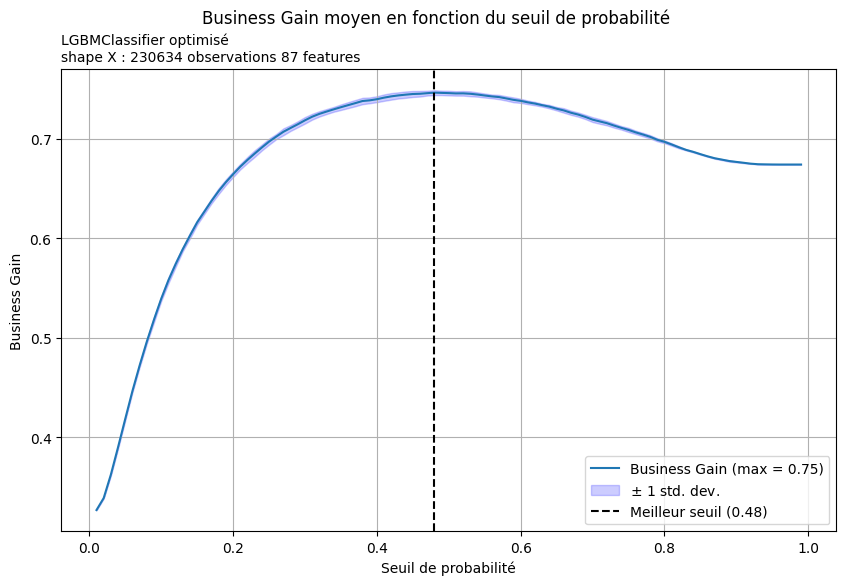

In [47]:
optim_lgbm_threshold = OptimThreshold(
    model=best_model_lgbm, mlflow_experiment_name="optim_4_lgbm_threshold"
)
optim_lgbm_threshold.optimize(X=X, y=y, param_bg=param_bg)

In [48]:
optim_lgbm_threshold.best_results

{'model_params': {'boosting_type': 'gbdt',
  'class_weight': 'balanced',
  'colsample_bytree': 0.8129221232621212,
  'importance_type': 'split',
  'learning_rate': 0.016300066315934513,
  'max_depth': -1,
  'min_child_samples': 62,
  'min_child_weight': 0.001,
  'min_split_gain': 0.7870491861754971,
  'n_estimators': 800,
  'n_jobs': 14,
  'num_leaves': 244,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'subsample': 0.7553729073561358,
  'subsample_for_bin': 200000,
  'subsample_freq': 0,
  'force_col_wise': True,
  'verbosity': -1},
 'bg_params': {'loss_fn': -10, 'loss_fp': -1, 'gain_tn': 1, 'gain_tp': 1},
 'threshold_prob': 0.48000000000000004,
 'business_gain': 0.7463688098978739}

In [49]:
best_threshold_lgbm = round(optim_lgbm_threshold.best_results["threshold_prob"], 2)
best_threshold_lgbm

0.48

## Evaluation du modèle LightGBM optimisé en validation croisée

In [50]:
# Pour enregistrer les modèles avec signature, on cast proprement les données
features = read_pkl("features_rfecv_lightgbm")
print()
X, y = read_train(features=features, clean_dtype=True)

pipe = best_model_lgbm

evaluator = EvaluatorCV(
    pipe=pipe,
    device="cpu",
    cv=5,
    threshold_prob=best_threshold_lgbm,
    random_state=VAL_SEED,
)
run_name = "lightgbm_balanced_optimized"
run_tags = {"balancing": evaluator.balance_str, "optim": "Oui"}
run_description = "LightGBM balanced features RFECV Hyperparamètres et seuil optimisés"
with mlflow.start_run(
    experiment_id=exp_evaluation_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator.evaluate(X, y)
    _ = evaluator.get_business_gain()

Objet list lu dans models/features_rfecv_lightgbm.pkl

Memory usage of dataframe is 155.67 MB
Memory usage after optimization is: 92.33 MB
Decreased by 40.7%
Cast des features

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Data columns (total 87 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   CODE_GENDER                            230634 non-null  float64
 1   AMT_ANNUITY                            230626 non-null  float32
 2   REGION_POPULATION_RELATIVE             230634 non-null  float32
 3   DAYS_BIRTH                             230634 non-null  float64
 4   DAYS_EMPLOYED                          189075 non-null  float32
 5   DAYS_REGISTRATION                      230634 non-null  float32
 6   DAYS_ID_PUBLISH                        230634 non-null  float64
 7   OWN_CAR_AGE                            78227 non-null   float32
 8   REGI

In [51]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator.get_mean_val_scores(prefix="val_")
    train_scores = evaluator.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = evaluator.get_model_params()
    mlflow.log_params(params)

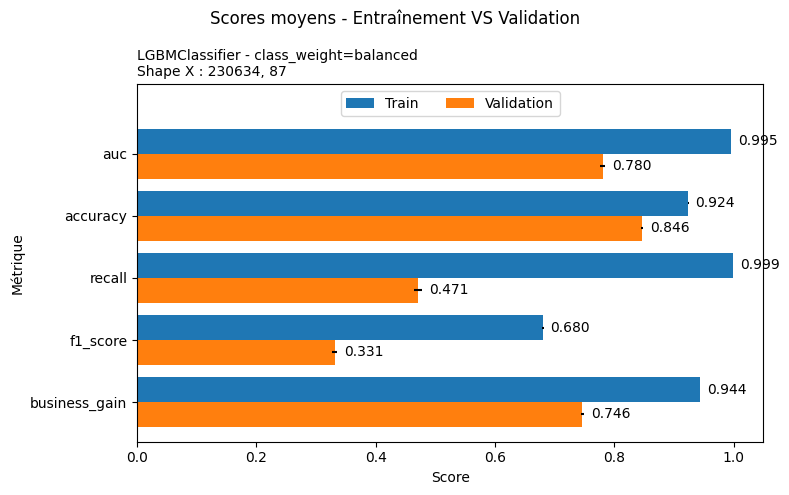

In [52]:
fig = evaluator.plot_evaluation_scores()

In [53]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_evaluation_scores")

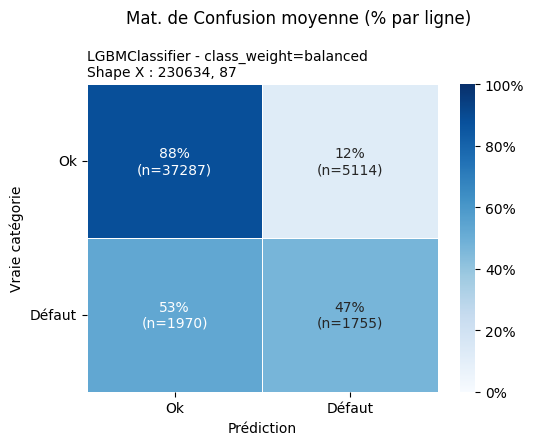

In [54]:
fig = evaluator.plot_conf_mat()
fig

In [55]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_confusion_matrix")

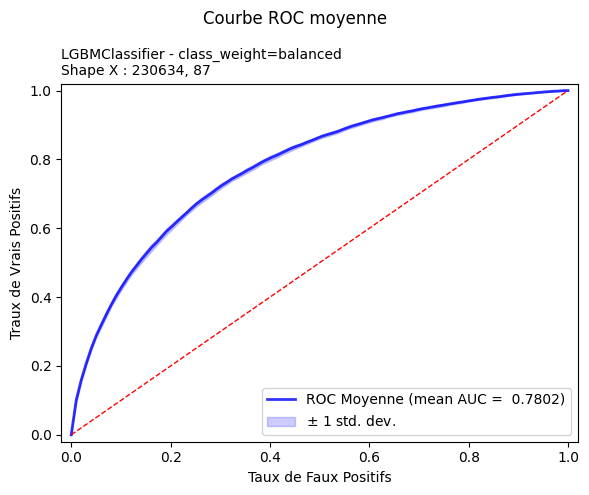

In [56]:
fig = evaluator.plot_roc_curve()

In [57]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_roc_curve")

In [58]:
with mlflow.start_run(run_id=run_id):
    log_features(X)

In [59]:
with mlflow.start_run(run_id=run_id):
    bg_params = evaluator.get_bg_params()
    threshold_prob = evaluator.threshold_prob
    log_scoring_params(bg_params, threshold_prob)

In [60]:
pipe.fit(X, y)

with mlflow.start_run(run_id=run_id):
    # On logue le modèle (il aparaîtra dans la colonne modèle de l'interface web mlflow)
    mlflow.sklearn.log_model(pipe, artifact_path="model")

    # On enregistre le modèle dans le Model Registry
    # En créant une nouvelle version
    model_uri = f"runs:/{run.info.run_id}/model"
    registered_model = mlflow.register_model(model_uri, name="LightGBM")
    print(
        f"Modèle enregistré avec le nom : {registered_model.name}, et la version : {registered_model.version}"
    )

Registered model 'LightGBM' already exists. Creating a new version of this model...
2025/06/07 02:02:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 3


Modèle enregistré avec le nom : LightGBM, et la version : 3


Created version '3' of model 'LightGBM'.


## Enregistrement dans le tableau comparatif

In [61]:
# On ajoute le meilleur modèle de régression logistique optimisé au tableau comparatif
cmp_eval.add(evaluator=evaluator, tags={"description": "Optimisé"})
cmp_eval.display()

Comparatif Modèles


model_name              balancing threshold business_gain     auc  \
0  LogisticRegression                  SMOTE      0.50        0.6990  0.7565   
1      LGBMClassifier  class_weight=balanced      0.50        0.7191  0.7801   
2  LogisticRegression                  SMOTE      0.70        0.7312  0.7566   
3      LGBMClassifier  class_weight=balanced      0.48        0.7464  0.7803   

   recall f1_score fit_time      fn  n_feat.         description  
0  0.6677   0.2714      2.4  1238.2      103  Avant optimisation  
1  0.6839   0.2918      1.2  1177.8       87  Avant optimisation  
2  0.3981   0.3032     33.9  2242.4      103            Optimisé  
3  0.4711   0.3313     20.4  1970.4       87            Optimisé

In [62]:
save_pkl(cmp_eval, "cmp_eval_with_optim")

Objet ComparativeTable engistré(e) dans models/cmp_eval_with_optim.pkl


## Test du modèle sur le jeu de test

In [63]:
from src.modeling.p7_evaluate import Evaluator

In [64]:
# On ne trace pas dans mlflow car ce sont bien les résultats de validation croisés qui font foi
# En effet, les résultats sur le jeu de test dépendent de la graine de hasard que nous avons utilisés pour créer le jeu de test.
features = read_pkl("features_rfecv_lightgbm")
print()
X_train, y_train = read_train(features=features)
X_test, y_test = read_train(
    directory=DATA_INTERIM, train_name="01_v0_built_test.csv", features=features
)
print()

pipe = best_model_lgbm
testor = Evaluator(
    pipe=pipe,
    threshold_prob=best_threshold_lgbm,
    random_state=VAL_SEED,
)


testor.evaluate(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)
_ = testor.get_business_gain()
val_scores = testor.get_test_scores(prefix="val_")
train_scores = testor.get_train_scores(prefix="train_")
scores = {**train_scores, **val_scores}

Objet list lu dans models/features_rfecv_lightgbm.pkl

Memory usage of dataframe is 155.67 MB
Memory usage after optimization is: 92.33 MB
Decreased by 40.7%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Data columns (total 87 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   CODE_GENDER                            230634 non-null  int32  
 1   AMT_ANNUITY                            230626 non-null  float32
 2   REGION_POPULATION_RELATIVE             230634 non-null  float32
 3   DAYS_BIRTH                             230634 non-null  int64  
 4   DAYS_EMPLOYED                          189075 non-null  float32
 5   DAYS_REGISTRATION                      230634 non-null  float32
 6   DAYS_ID_PUBLISH                        230634 non-null  int64  
 7   OWN_CAR_AGE                            78227 non-null   float32
 8   REGION_RATING_CLIENT_W

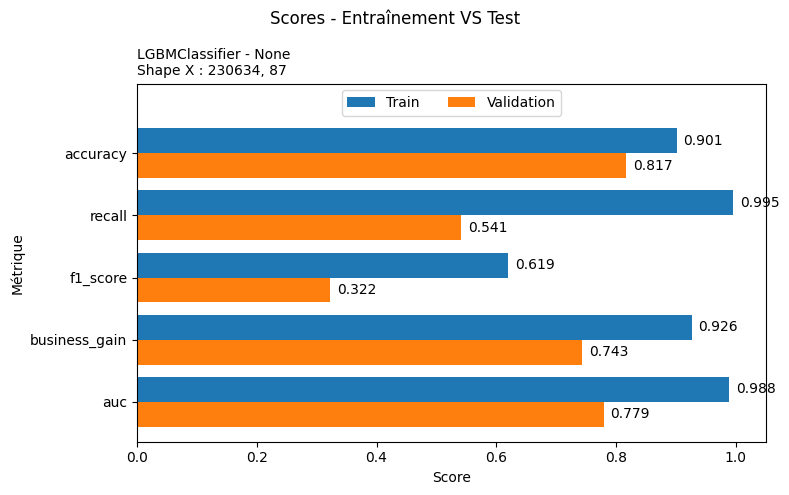

In [65]:
_ = testor.plot_evaluation_scores()

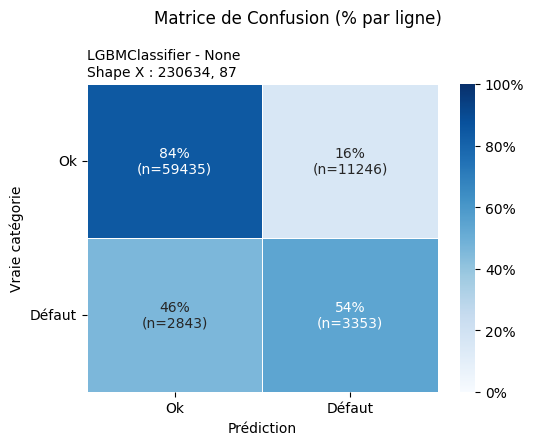

In [66]:
testor.plot_conf_mat()

# Conclusion

In [ ]:
"""
Notre modèle le plus performant est le modèle LightGBM
Pour que ce soit plus pratique dans la suite du projet, nous enregistrons le modèle, le train et les nouveaux emprunts avec ses features.
"""

In [67]:
# Sauvegarde du modèle et du seuil de probabilité
# (Ce modèle n'est pas signé comme la V2 registered mais nous pourrons reprendre la V2 de la base de registre si nous en avons besoin)
save_pkl(best_model_lgbm, "best_model_lgbm")
save_pkl(best_threshold_lgbm, "best_threshold_lgbm")

Objet LGBMClassifier engistré(e) dans models/best_model_lgbm.pkl
Objet float64 engistré(e) dans models/best_threshold_lgbm.pkl


In [68]:
# Train avec les features concernées uniquement
filepath = os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv")
features_lgbm = read_pkl("features_rfecv_lightgbm")
train_lgbm = pd.read_csv(filepath)[["SK_ID_CURR", "TARGET"] + features_lgbm]

Objet list lu dans models/features_rfecv_lightgbm.pkl


In [69]:
train_lgbm.head()

SK_ID_CURR  TARGET  CODE_GENDER  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
0      127032       0            1      16672.5                    0.031329   
1      148207       0            1      21546.0                    0.028663   
2      343318       0            1      53775.0                    0.011703   
3      307778       0            1      22977.0                    0.009630   
4      260591       0            0      54688.5                    0.007330   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -23528            NaN           -11467.0            -4116          NaN   
1      -12273        -3034.0            -3557.0            -3557          NaN   
2      -20583         -611.0            -5214.0            -3748         21.0   
3       -8089         -876.0            -8089.0             -712          NaN   
4      -23282        -1979.0            -6216.0            -4940          NaN   

   ...  INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM  \
0  ...                 9644.332031               2.121753e+05   
1  ...                 5966.736328               2.148025e+05   
2  ...                72310.125000               1.663133e+06   
3  ...                23757.322270               1.425439e+05   
4  ...                 6344.168457               1.459159e+05   

   INSTAL_AMT_PAYMENT_MIN  INSTAL_DAYS_ENTRY_PAYMENT_MAX  \
0             5757.120117                          -26.0   
1             2629.800049                         -379.0   
2             8838.495117                         -206.0   
3            23755.859380                         -468.0   
4             3312.629883                        -1250.0   

   INSTAL_DAYS_ENTRY_PAYMENT_SUM  CC_AMT_BALANCE_MEAN  \
0                       -19035.0                  NaN   
1                       -75261.0                  NaN   
2                       -28450.0                  NaN   
3                        -3261.0                  NaN   
4                       -39033.0                  NaN   

   CC_AMT_PAYMENT_CURRENT_SUM  CC_CNT_DRAWINGS_ATM_CURRENT_MEAN  \
0                         NaN                               NaN   
1                         NaN                               NaN   
2                         NaN                               NaN   
3                         NaN                               NaN   
4                         NaN                               NaN   

   CC_CNT_DRAWINGS_CURRENT_MEAN  CC_CNT_DRAWINGS_CURRENT_VAR  
0                           NaN                          NaN  
1                           NaN                          NaN  
2                           NaN                          NaN  
3                           NaN                          NaN  
4                           NaN                          NaN  

[5 rows x 89 columns]

In [70]:
filepath = os.path.join(DATA_CLEAN_DIR, "train_lgbm.csv")
train_lgbm.to_csv(filepath, index=False)
print(
    f"Jeu de train pour le meilleur modèle (shape = {train_lgbm.shape}) enregistré dans {filepath}"
)

Jeu de train pour le meilleur modèle (shape = (230634, 89)) enregistré dans data/cleaned/train_lgbm.csv


In [180]:
from src.modeling.p7_simple_kernel import build_X_new_loans

In [181]:
# Jeu de nouveaux emprunts (issus de Application_test) sans Target avec les features concernées uniquement
X_new_loans_lgbm = build_X_new_loans(features=features_lgbm)

Paramètres ['debug', 'drop_first', 'na_value'] mis à jour
Configuration :
	dataset_num : 01
	debug : False
	n_rows : None
	drop_first : False
	frac_test : 0.25
	test_is_stratified : True
	input_dir : data/base/
	output_dir : data/interim/
	train_name : 01_v0_built_train.csv
	test_name : 01_v0_built_test.csv
	na_value : nan
	features_label_encoding : []
	features_oh_encoded : []
	random_state : 42
Nombre de lignes pour les demandes de prêts récentes: 48744
Process Application - duration (hh:mm:ss) : 0:00:00
Bureau df shape: (305811, 112)
Process bureau and bureau_balance - duration (hh:mm:ss) : 0:00:03
Previous applications df shape: (338857, 235)
Process previous_applications - duration (hh:mm:ss) : 0:00:03
Pos-cash balance df shape: (337252, 17)
Process POS-CASH balance - duration (hh:mm:ss) : 0:00:02
Installments payments df shape: (339587, 26)
Process installments payments - duration (hh:mm:ss) : 0:00:02
Credit card balance df shape: (103558, 122)
Process credit card balance - durat

In [182]:
X_new_loans_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 258223 to 424220
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CODE_GENDER                            48744 non-null  bool   
 1   AMT_ANNUITY                            48720 non-null  float32
 2   REGION_POPULATION_RELATIVE             48744 non-null  float32
 3   DAYS_BIRTH                             48744 non-null  int64  
 4   DAYS_EMPLOYED                          39470 non-null  float32
 5   DAYS_REGISTRATION                      48744 non-null  float32
 6   DAYS_ID_PUBLISH                        48744 non-null  int64  
 7   OWN_CAR_AGE                            16432 non-null  float32
 8   REGION_RATING_CLIENT_W_CITY            48744 non-null  int32  
 9   EXT_SOURCE_1                           28212 non-null  float32
 10  EXT_SOURCE_2                           48736 non-null  float32
 11  E

In [183]:
X_new_loans_lgbm.head()

CODE_GENDER  AMT_ANNUITY  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                                     
258223            False      22117.5                    0.022625      -19708   
258231            False      23305.5                    0.011703       -9787   
258259            False      69385.5                    0.035792      -18434   
258281             True      53329.5                    0.016612      -15592   
258305            False      34956.0                    0.008575      -17244   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
258223             -154.0            -4102.0            -3141          NaN   
258231            -1501.0             -145.0            -1098          8.0   
258259                NaN             -868.0            -1979          NaN   
258281            -1608.0            -1070.0            -2145          NaN   
258305            -3220.0            -8007.0             -631          1.0   

            REGION_RATING_CLIENT_W_CITY  EXT_SOURCE_1  ...  \
SK_ID_CURR                                             ...   
258223                                2           NaN  ...   
258231                                2      0.350171  ...   
258259                                2      0.462064  ...   
258281                                2           NaN  ...   
258305                                2           NaN  ...   

            INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM  \
SK_ID_CURR                                                          
258223                    20127.917969               1.268059e+06   
258231                     9652.722656               7.529124e+05   
258259                    10658.890625               1.705422e+06   
258281                     8011.533203               4.486459e+05   
258305                    38939.343750               8.177262e+05   

            INSTAL_AMT_PAYMENT_MIN  INSTAL_DAYS_ENTRY_PAYMENT_MAX  \
SK_ID_CURR                                                          
258223                    7.605000                          -37.0   
258231                    0.765000                         -217.0   
258259                   32.084999                          -13.0   
258281                   93.464996                          -24.0   
258305                 1429.380005                          -28.0   

            INSTAL_DAYS_ENTRY_PAYMENT_SUM  CC_AMT_BALANCE_MEAN  \
SK_ID_CURR                                                       
258223                           -38820.0         95575.390625   
258231                           -59586.0         50868.949219   
258259                          -169819.0          5912.852051   
258281                           -13935.0         62785.449219   
258305                            -3759.0             0.000000   

            CC_AMT_PAYMENT_CURRENT_SUM  CC_CNT_DRAWINGS_ATM_CURRENT_MEAN  \
SK_ID_CURR                                                                 
258223                   214705.671875                          0.615385   
258231                   182925.000000                          0.000000   
258259                   971718.187500                          0.000000   
258281                   132522.968750                          0.000000   
258305                   270000.000000                          1.571429   

            CC_CNT_DRAWINGS_CURRENT_MEAN  CC_CNT_DRAWINGS_CURRENT_VAR  
SK_ID_CURR                                                             
258223                          0.432432                     1.030030  
258231                          3.941176                    42.683823  
258259                          2.198113                    64.979424  
258281                          7.545455                    71.872726  
258305                          1.571429                    17.285715  



In [ ]:
# On enregistre le jeu de nouveaux emprunts
filepath = os.path.join(DATA_CLEAN_DIR, "X_new_loans_lgbm.csv")
X_new_loans_lgbm.to_csv(filepath, index=True)
print(
    f"Jeu de nouveaux emprunts pour LightGBM (shape : {X_new_loans_lgbm.shape}) enregistré dans {filepath}"
)
print("Il est indexé par 'SK_ID_CURR' et ne contient pas de TARGET")

Jeu de nouveaux emprunts pour LightGBM (shape : (48744, 87)) enregistré dans data/cleaned/X_new_loans_lgbm.csv
Il est indexé par 'SK_ID_CURR' et ne contient pas de TARGET


# Suppression d'experience mlflow (expériences commençant par debug)

In [72]:
from src.modeling.p7_tracking import delete_experiments_with_prefix

In [73]:
start_mlflow_ui()
delete_experiments_with_prefix(prefix="debug")

L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000
2 expériences à supprimer dans mlflow :
['debug_optim_3_lightGBM_params', 'debug_optim_1_logreg_params']


['debug_optim_3_lightGBM_params', 'debug_optim_1_logreg_params']

In [5]:
start_mlflow_ui()

L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000


<Popen: returncode: None args: ['mlflow', 'ui', '--port', '5000', '--backend...>